In [196]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from matplotlib.pylab import rcParams


In [4]:
with open("pickled_table.pkl", "rb") as file:
    data = pickle.load(file)

In [70]:
class Data_balancing:
    def __init__(self, data) -> None:
        self.data = data
        self.ones = self.data[self.data[self.data.columns[-1]] == 1]
        self.zeros = self.data[self.data[self.data.columns[-1]] == 0]    
    
    def counts(self):
        counts = self.data.loc[:,self.data.columns[-1]].value_counts()
        return f"Count of zeros - {counts[0]},\ncount of ones - {counts[1]}."

    def balancing(self, counts):
        return self.zeros.sample(counts)

    def concat_balance(self):
        return pd.concat([self.ones, self.balancing(self.ones.shape[0])])

In [87]:
b_data = Data_balancing(data).concat_balance().reset_index().drop(["index"], axis=1)

In [105]:
class Transformation:
    def __init__(self, data) -> None:
        self.standard = StandardScaler().fit(data)
        self.scaling = MinMaxScaler().fit(data)
    
    def standarization(self, d):
        return self.standard.transform(d)

    def scal(self, d):
        return self.scaling.transform(d)

In [101]:
x = b_data.drop(b_data.columns[-1], axis=1)
y = b_data[b_data.columns[-1]]

In [106]:
x_standarized = Transformation(x).standarization(x)
x_scaling = Transformation(x).scal(x)

In [206]:
class Split:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
    
    def splitting(self):
        return train_test_split(self.x, self.y, test_size=0.1, random_state=42) 

In [207]:
train_x, test_x, train_y, test_y = Split(x, y).splitting()
st_train_x, st_test_x, st_train_y, st_test_y = Split(x_standarized, y).splitting()
sc_train_x, sc_test_x, sc_train_y, sc_test_y = Split(x_scaling, y).splitting()

In [208]:
class Basic_model_check:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        self.model = xgb.XGBClassifier()

    def training(self):
        return self.model.fit(self.x, self.y)

    def score(self, test_x, test_y):
        return self.training().score(test_x, test_y)

    def report(self, x_test, y_test):
        pred = self.training().predict(x_test)
        return classification_report(y_test, pred), confusion_matrix(y_test, pred)

In [209]:
basic = Basic_model_check(train_x, train_y)
standard = Basic_model_check(st_train_x, st_train_y)
scaled = Basic_model_check(sc_train_x, sc_train_y)

In [210]:
print(basic.report(x_test=test_x, y_test=test_y)[1])
print(standard.report(x_test=st_test_x, y_test=st_test_y)[1])
print(scaled.report(x_test=sc_test_x, y_test=sc_test_y)[1])
#no differances between prepared data, not standarized data will be chosed to further tunning

[[ 7  3]
 [ 0 12]]
[[ 7  3]
 [ 0 12]]
[[ 7  3]
 [ 0 12]]


In [211]:
model = xgb.XGBClassifier().fit(train_x, train_y)

In [212]:
pred = model.predict(test_x)

In [202]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

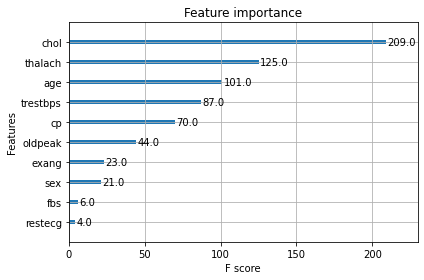

In [213]:
xgb.plot_importance(model)
plt.tight_layout()
plt.show()

In [214]:
roc_auc_score(test_y, pred)

0.85

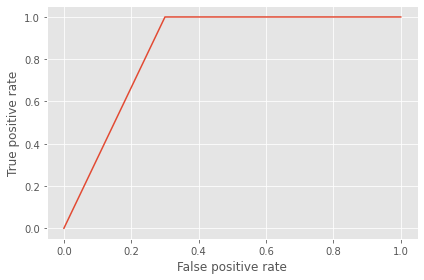

In [229]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, pred)

plt.style.use("ggplot")
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.tight_layout()
plt.show()

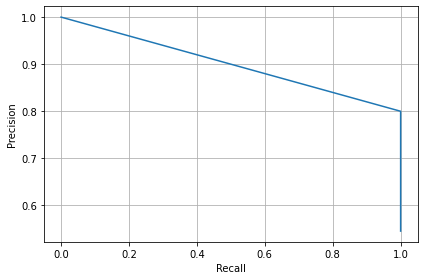

In [222]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(test_y, pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.tight_layout()
plt.show()